Для начала подключим все нужные библиотеки:

In [87]:
!pip install PyPDF2
!pip install pymupdf requests
!pip install pandasql
!pip install pandas gdown openpyxl
!pip install -U kaleido

import PyPDF2
from PyPDF2 import PdfReader
from google.colab import drive
import requests
from bs4 import BeautifulSoup
from io import BytesIO
import pandas as pd
import gdown
from scipy.stats import gmean
import pandasql as psql
import re
import fitz
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, shapiro
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import statsmodels.api as sm

Первое, что я хочу сделать, — оценить значение индекса самовыражения, так как в открытом доступе результатов опросов нет. Можно обратиться к аналогичным опросам Gallup, которые, в свою очередь, являются ещё более точными и репрезентативными, и скомбинировать их так, чтобы они давали результат, похожий на индекс самовыражения Инглхарта. Я хочу взять 4 характеристики ценностей самовыражения: это желание гражданского и политического участия, акцент на важности меличностного доверия и социальной толерантности, а также приоритизацию счастья и удовлетворённости жизнью. Вопросы, касающиеся каждой из 4-х тем, составляют значимую часть опросников Инглхарта.

Ещё одна проблема заключается в том, что результатов опросов Gallup в открытом доступе тоже нет, но они являются составляющими компонентами некоторых индексов уровня жизни. Так, например, Legatum Prosperity Index учитывает нужные нам характеристики, взятые из опросов Gallup, и помещает их в информацию по каждой стране. Давайте постараемся получить нужные нам данные с помощью веб-скрэппинга. Поместим URL профилей всех стран в одну переменную:

In [2]:
def get_pdf_links(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    pdf_links = []
    for link in soup.find_all('a', href=True):
        href = link['href']
        if href.endswith('.pdf'):
            pdf_links.append(href)

    return pdf_links

url = 'https://www.prosperity.com/all-countries'
pdf_links = get_pdf_links(url)

Теперь прочитаем pdf файлы и запишем текст из них в список из строк:

In [ ]:
def pdf_to_text(pdf_url):
    response = requests.get(pdf_url)
    file = BytesIO(response.content)

    reader = PyPDF2.PdfReader(file)
    text = ""
    for page_num in range(len(reader.pages)):
        page = reader.pages[page_num]
        text += page.extract_text() + "\n"

    return text

texts = []
for link in pdf_links:
    text = pdf_to_text(link)
    texts.append(text)

Подключим Google Drive, чтоб сохранять все файлы в одну папку:

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
folder = '/content/gdrive/My Drive/project/'

Mounted at /content/gdrive


Закинем наш список строк в папку:

In [ ]:
with open(folder + 'string_list.txt', 'w') as f:
    for item in texts:
        f.write("%s\n" % item)

Напишем фрагмент кода, чтоб можно было доставать список, когда снова посещаешь код:

In [ ]:
texts = []
with open(folder + 'string_list.txt', 'r') as f:
    string_list = f.readlines()
    texts = [line.strip() for line in string_list]

Теперь достанем нужные нам данные из текстовых переменных и поместим их в датафрейм. В нём предварительно посчитаем индекс самовыражения, не учитывая показатели удовлетворённости жизнью. Данные извлечём за 2013 и 2023 года:

In [ ]:
def extract_data(text):
    lines = text.split('\n')
    country = lines[1].split(':')[0].strip()
    st1, st2, it1, it2, cp1, cp2 = "Non", "Non", "Non", "Non", "Non", "Non"
    p1, p2, p3, p4, p5, p6, p7, p8, p9, p10 = "Non", "Non", "Non", "Non", "Non", "Non", "Non", "Non", "Non", "Non"
    for line in lines:
        if "Social Tolerance 20%" in line:
            numbers1 = line.split("Social Tolerance 20%")[1].strip().split()[:2]
            st1, st2 = map(float, numbers1)
        if "Interpersonal Trust 20%" in line:
            numbers2 = line.split("Interpersonal Trust 20%")[1].strip().split()[:2]
            it1, it2 = map(float, numbers2)
        if "Civic and Social Participation 20%" in line:
            numbers3 = line.split("Civic and Social Participation 20%")[1].strip().split()[:2]
            cp1, cp2 = map(float, numbers3)
    return country, st1, st2, it1, it2, cp1, cp2
data = [extract_data(text) for text in texts]
df = pd.DataFrame(data, columns=['Country', 'Social Tolerance 2013', 'Social Tolerance 2023', 'Interpersonal Trust 2013', 'Interpersonal Trust 2023', 'Civic and Social Participation 2013', 'Civic and Social Participation 2023'])
columns_to_convert = [
    'Social Tolerance 2013', 'Social Tolerance 2023',
    'Interpersonal Trust 2013', 'Interpersonal Trust 2023',
    'Civic and Social Participation 2013', 'Civic and Social Participation 2023'
]

for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce')

df['Self_Expression_2013'] = df[['Social Tolerance 2013', 'Interpersonal Trust 2013', 'Civic and Social Participation 2013']].mean(axis=1).round(1)
df['Self_Expression_2023'] = df[['Social Tolerance 2023', 'Interpersonal Trust 2023', 'Civic and Social Participation 2023']].mean(axis=1).round(1)

df.sample(5)

Поместим наш датафрейм в папку:

In [ ]:
df.to_excel(folder + 'dataframe.xlsx', index=False)

Теперь извлечём текст из отчёта ООН об индексе счастья за 2023 год:

In [94]:
url = "https://happiness-report.s3.amazonaws.com/2023/WHR+23.pdf"
response = requests.get(url)

with open("World_Happiness_Report_2023.pdf", "wb") as f:
    f.write(response.content)

pdf_document = fitz.open("World_Happiness_Report_2023.pdf")

text = ""
for page_num in range(33, 38):
    page = pdf_document.load_page(page_num)
    text += page.get_text()

pdf_document.close()

Определим нужные нам данные с помошью регулярных выражений и поместим их в датафрейм:

In [95]:
pattern = re.compile(r'([A-Z][A-Za-z\s\(\)\*\'\.,-]+)\n(\d\.\d{3})')

matches = pattern.findall(text)

df_2 = pd.DataFrame(matches, columns=['Country', 'Index_2023'])

df_2 = df_2.drop_duplicates(subset=['Country'])

df_2.sample(5)

Аналогичное проделаем с отчётом за 2013 год:

In [96]:
url = "https://s3.amazonaws.com/happiness-report/2013/WorldHappinessReport2013_online.pdf"
response = requests.get(url)
pdf_content = BytesIO(response.content)

pdf_reader = PdfReader(pdf_content)

data = ""
for page_num in range(22, 27):
    page = pdf_reader.pages[page_num]
    data += page.extract_text()

Для него сначала создадим отдельный датафрейм:

In [97]:
pattern = r'\d+\.\s([A-Za-z\s\(\)-]+)\s\((\d+\.\d+)'
matches = re.findall(pattern, data)
df_3 = pd.DataFrame(matches, columns=['Country', 'Index_2013'])
df_3['Index_2013'] = df_3['Index_2013'].astype(float)
df_3['Country'] = df_3['Country'].str.strip()
df_3.to_excel(folder + 'dataframe_3.xlsx', index=False)

df_3.sample(5)

Отредактируем датафрей с данными за 2023 год, чтоб можно было находить совпадения:

In [98]:
df_2['Index_2023'] = df_2['Index_2023'].astype(float)
df_2['Country'] = df_2['Country'].str.strip()

df_2['Country'] = df_2['Country'].astype(str).str.replace('*', '')

df_2 = df_2.loc[df_2['Country'] != 'Province of China']
df_2 = df_2.loc[df_2['Country'] != 'Republic of']
df_2 = df_2.loc[df_2['Country'] != 'Emirates']
df_2['Country'] = df_2['Country'].replace('Congo, Republic of', 'Congo (Brazzaville)')
df_2['Country'] = df_2['Country'].replace('Congo, Democratic Republic of', 'Congo (Kinshasa)')
df_2['Country'] = df_2['Country'].replace('Czechia', 'Czech Republic')
df_2['Country'] = df_2['Country'].replace('Hong Kong S.A.R. of China', 'Hong Kong')
df_2['Country'] = df_2['Country'].replace('Korea, Republic of', 'South Korea')
df_2['Country'] = df_2['Country'].replace('Taiwan Province of China', 'Taiwan')
df_2['Country'] = df_2['Country'].replace('Russian Federation', 'Russia')
df_2['Country'] = df_2['Country'].replace('Palestine, State of', 'Palestinian Territories')
df_2['Country'] = df_2['Country'].replace('Moldova, Republic of', 'Moldova')
df_2['Country'] = df_2['Country'].replace('North Macedonia', 'Macedonia')
df_2['Country'] = df_2['Country'].replace('Lao People\'s Democratic Republic', 'Laos')
new_row = {'Country': 'Turkey', 'Index_2023': 4.614}
df_2.loc[len(df_2)] = new_row
df_2.loc[df_2["Country"] == "Jamaica", "Index_2023"] = 5.703

df_2.to_excel(folder + 'dataframe_2.xlsx', index=False)

df_2.sample(5)

Теперь объединим датафреймы с данными за 2013 и 2023 года, для этого удобно применить SQL-запрос, используя команду INNER JOIN. Получившийся датафрейм тоже поместим в папку:

In [99]:
query = """
SELECT df_2.Country, df_2.Index_2023, df_3.Index_2013
FROM df_2
INNER JOIN df_3
ON df_2.Country = df_3.Country
"""

result = psql.sqldf(query, globals())

result.to_excel(folder + 'happiness.xlsx', index=False)

result.sample(5)

Следующий фрагмент нужен лишь чтобы не запускать заново код, а достать нужные файлы из папки

In [3]:
df = pd.read_excel(folder + 'dataframe.xlsx')
result = pd.read_excel(folder + 'happiness.xlsx')

Теперь мы проделаем аналогичные действия с первой табицей и совместим их:

In [4]:
df['Country'] = df['Country'].replace('Czechia', 'Czech Republic')
df['Country'] = df['Country'].replace('Taiwan, China', 'Taiwan')
df['Country'] = df['Country'].replace('North Macedonia', 'Macedonia')
df['Country'] = df['Country'].replace('Congo', 'Congo (Brazzaville)')
df['Country'] = df['Country'].replace('Democratic Republic of Congo', 'Congo (Kinshasa)')

query_2 = """
SELECT result.Country, result.Index_2023, result.Index_2013, df.Self_Expression_2013, df.Self_Expression_2023
FROM result
INNER JOIN df
ON result.Country = df.Country
"""

result_2 = psql.sqldf(query_2, globals())

result_2.sample(5)

,Country,Index_2023,Index_2013,Self_Expression_2013,Self_Expression_2023
103,Pakistan,4.555,5.292,36.7,39.8
12,Canada,6.961,7.477,73.6,71.7
131,Turkey,4.614,5.345,20.6,40.0
110,Cambodia,4.393,4.067,34.6,31.5
36,Panama,6.265,7.143,46.6,46.7


Так как удовлетворённость жизнью более значимый и при этом менее волатильный параметр, в сранениии с остальными, возьмём его с большим весом. При этом, важно, что если остальные показатели слишком низкие, то и общий индекс должен быть низким, для этого возьмём среднее геометрическое, используя numpy:

In [5]:
def geometric_mean(a, b):
    return np.sqrt(a * b)

result_2['GeoMean_2013'] = geometric_mean(result_2['Self_Expression_2013'], result_2['Index_2013'] / 10).round(3)
result_2['GeoMean_2023'] = geometric_mean(result_2['Self_Expression_2023'], result_2['Index_2023'] / 10).round(3)

result_2['Self_Expression_2013'] = result_2['GeoMean_2013']
result_2['Self_Expression_2023'] = result_2['GeoMean_2023']

result_2.drop(columns=['GeoMean_2013', 'GeoMean_2023'], inplace=True)

result_2['Change'] = result_2['Self_Expression_2023'] - result_2['Self_Expression_2013']

result_2.to_excel(folder + 'selfexpression.xlsx', index=False)

result_2.sample(5)

,Country,Index_2023,Index_2013,Self_Expression_2013,Self_Expression_2023,Change
98,Iran,4.876,4.643,4.379,4.282,-0.097
22,Costa Rica,6.609,7.257,6.231,5.918,-0.313
72,Ecuador,5.559,5.865,4.563,5.013,0.450
57,Mauritius,5.902,5.477,5.270,5.545,0.275
116,Jordan,4.120,5.414,3.708,3.354,-0.354


Все следующие действия и датасеты будут использовать кода стран, а не названия, поэтому заменим в нашем получившемсся датафрейме названия стран на их кода, для этого запарсим страницу википедии с соответствием стран и их кодов:

In [6]:
url = "https://en.wikipedia.org/wiki/ISO_3166-1"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

tables = soup.find_all('table', {'class': 'wikitable sortable'})

iso_3166_1_table = tables[1]

headers = [header.text.strip() for header in iso_3166_1_table.find_all('th')]

rows = iso_3166_1_table.find_all('tr')

data = []

for row in rows[1:]:
    cells = row.find_all('td')
    if len(cells) > 0:
        country_name = cells[0].text.strip().split('[')[0]
        alpha_3_code = cells[2].text.strip()
        data.append([country_name, alpha_3_code])

codes = pd.DataFrame(data, columns=['Country Name', 'Alpha-3 Code'])

codes = codes.rename(columns={'Country Name': 'Country'})

codes.to_excel(folder + 'codes.xlsx', index=False)

codes.sample(5)

,Country,Alpha-3 Code
196,Senegal,SEN
88,Grenada,GRD
62,Dominica,DMA
153,Namibia,NAM
133,Malawi,MWI


In [7]:
result_2['Country'] = result_2['Country'].replace('Netherlands', 'Netherlands, Kingdom of the')
result_2['Country'] = result_2['Country'].replace('United States', 'United States of America')
result_2['Country'] = result_2['Country'].replace('United Kingdom', 'United Kingdom of Great Britain and Northern Ireland')
result_2['Country'] = result_2['Country'].replace('Czech Republic', 'Czechia')
result_2['Country'] = result_2['Country'].replace('South Korea', 'Korea, Republic of')
result_2['Country'] = result_2['Country'].replace('Taiwan', 'Taiwan, Province of China')
result_2['Country'] = result_2['Country'].replace('Russia', 'Russian Federation')
result_2['Country'] = result_2['Country'].replace('Turkey', 'Türkiye')
result_2['Country'] = result_2['Country'].replace('Bolivia', 'Bolivia, Plurinational State of')
result_2['Country'] = result_2['Country'].replace('Vietnam', 'Viet Nam')
result_2['Country'] = result_2['Country'].replace('Moldova', 'Moldova, Republic of')
result_2['Country'] = result_2['Country'].replace('Venezuela', 'Venezuela, Bolivarian Republic of')
result_2['Country'] = result_2['Country'].replace('Macedonia', 'North Macedonia')
result_2['Country'] = result_2['Country'].replace('Laos', 'Lao People\'s Democratic Republic')
result_2['Country'] = result_2['Country'].replace('Iran', 'Iran, Islamic Republic of')
result_2['Country'] = result_2['Country'].replace('Congo (Brazzaville)', 'Congo')
result_2['Country'] = result_2['Country'].replace('Tanzania', 'Tanzania, United Republic of')
result_2['Country'] = result_2['Country'].replace('Congo (Kinshasa)', 'Congo, Democratic Republic of the')

result_2 = pd.merge(result_2, codes, on='Country', how='left')
result_2 = result_2.rename(columns={'Alpha-3 Code': 'Code'})

result_2.to_excel(folder + 'selfexpression.xlsx', index=False)

result_2.sample(5)

,Country,Index_2023,Index_2013,Self_Expression_2013,Self_Expression_2023,Change,Code
38,Nicaragua,6.259,5.507,4.911,5.260,0.349,NIC
22,Costa Rica,6.609,7.257,6.231,5.918,-0.313,CRI
116,Jordan,4.120,5.414,3.708,3.354,-0.354,JOR
91,Gabon,5.035,4.114,3.938,4.744,0.806,GAB
45,Japan,6.129,6.064,5.142,4.970,-0.172,JPN


<ipython-input-8-b19a55284a05>:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


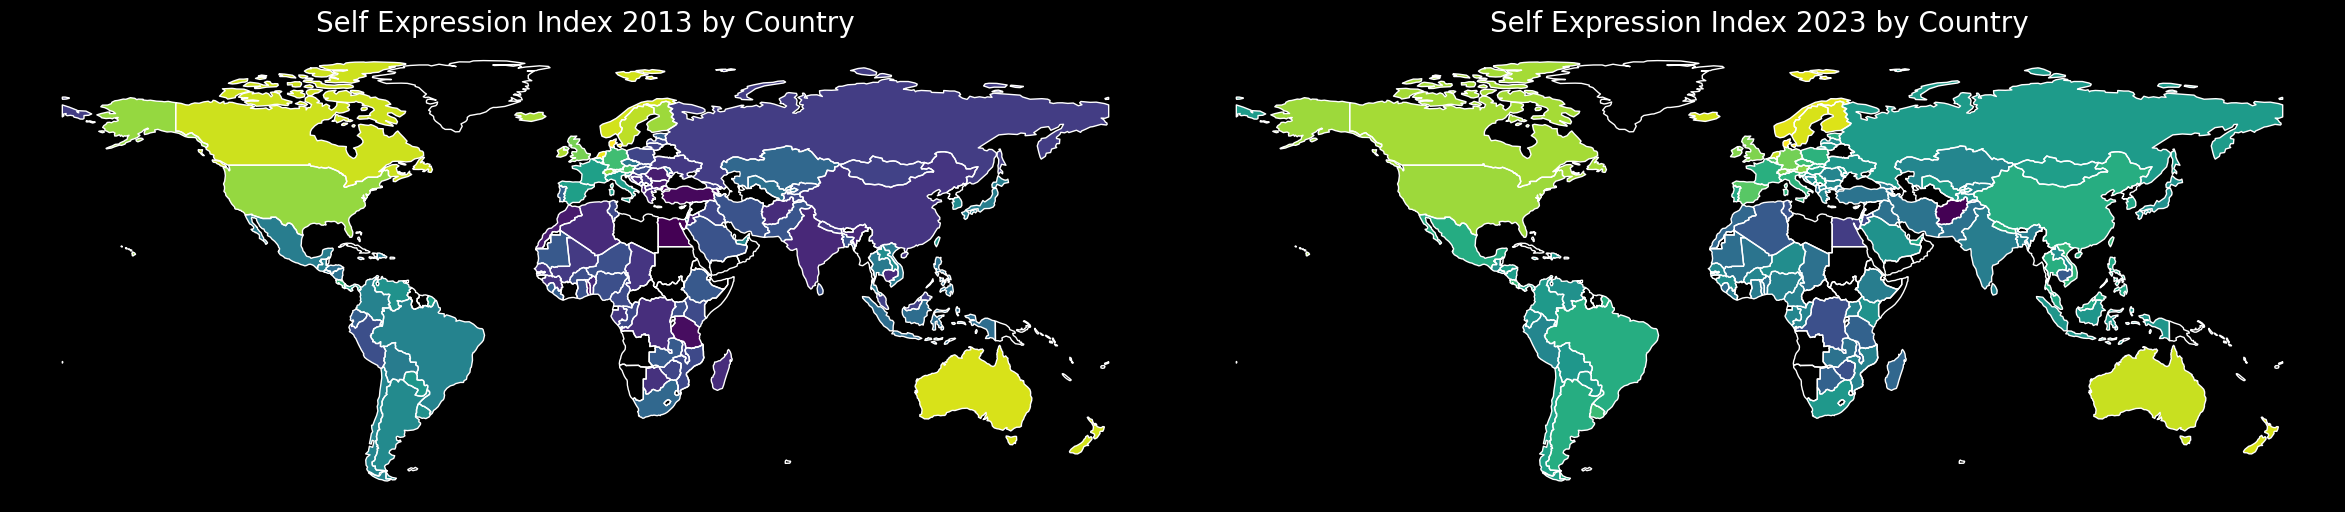

In [8]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world[(world.pop_est > 0) & (world.name != "Antarctica")]
world = world[['iso_a3', 'geometry']]

world = world.merge(result_2, how="left", left_on="iso_a3", right_on="Code")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15), facecolor='black')

world.boundary.plot(ax=ax1, linewidth=1, color='white')
world.plot(column='Self_Expression_2013', ax=ax1, cmap='viridis', missing_kwds={"color": "black"})

ax1.set_facecolor('black')
ax1.set_title('Self Expression Index 2013 by Country', color='white', size=20)
ax1.set_axis_off()

world.boundary.plot(ax=ax2, linewidth=1, color='white')
world.plot(column='Self_Expression_2023', ax=ax2, cmap='viridis', missing_kwds={"color": "black"})

ax2.set_facecolor('black')
ax2.set_title('Self Expression Index 2023 by Country', color='white', size=20)
ax2.set_axis_off()

plt.subplots_adjust(wspace=0.02)

plt.show()

fig.savefig(folder + 'self_expression_map.png', format='png', dpi=300)

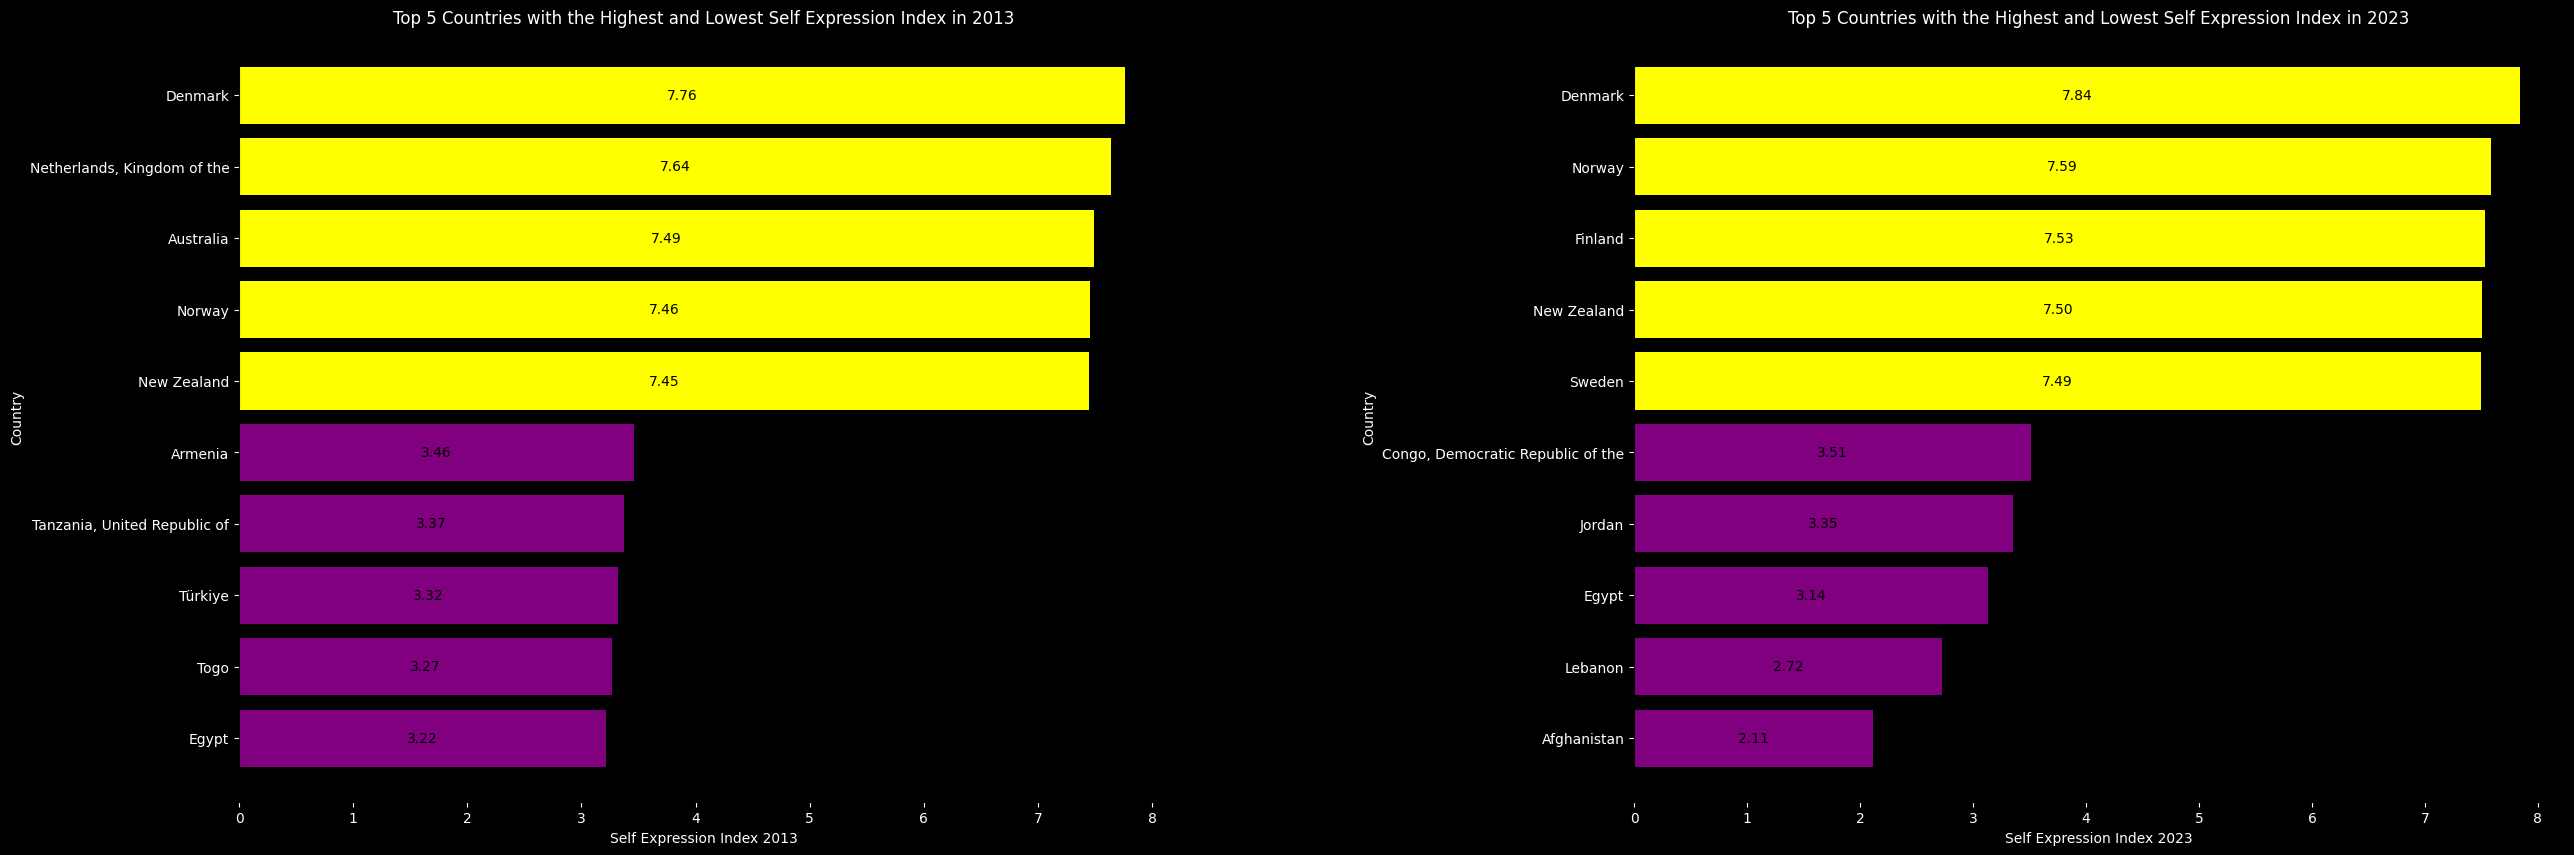

In [9]:
top5_highest_2013 = result_2.nlargest(5, 'Self_Expression_2013')
top5_lowest_2013 = result_2.nsmallest(5, 'Self_Expression_2013')

top5_highest_2023 = result_2.nlargest(5, 'Self_Expression_2023')
top5_lowest_2023 = result_2.nsmallest(5, 'Self_Expression_2023')

top_2013 = pd.concat([top5_highest_2013, top5_lowest_2013]).sort_values(by='Self_Expression_2013', ascending=True)
top_2023 = pd.concat([top5_highest_2023, top5_lowest_2023]).sort_values(by='Self_Expression_2023', ascending=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10), facecolor='black')
fig.subplots_adjust(wspace=0.5)

ax1.set_facecolor('black')
colors_2013 = ['purple' if i in top5_lowest_2013.index else 'yellow' for i in top_2013.index]
bars1 = ax1.barh(top_2013['Country'], top_2013['Self_Expression_2013'], color=colors_2013)

ax1.set_ylabel('Country', color='white')
ax1.set_xlabel('Self Expression Index 2013', color='white')
ax1.set_title('Top 5 Countries with the Highest and Lowest Self Expression Index in 2013', color='white')
ax1.tick_params(colors='white')

for bar in bars1:
    width = bar.get_width()
    ax1.text(width / 2, bar.get_y() + bar.get_height() / 2, f'{width:.2f}',
             ha='center', va='center', color='black')

ax2.set_facecolor('black')
colors_2023 = ['purple' if i in top5_lowest_2023.index else 'yellow' for i in top_2023.index]
bars2 = ax2.barh(top_2023['Country'], top_2023['Self_Expression_2023'], color=colors_2023)

ax2.set_ylabel('Country', color='white')
ax2.set_xlabel('Self Expression Index 2023', color='white')
ax2.set_title('Top 5 Countries with the Highest and Lowest Self Expression Index in 2023', color='white')
ax2.tick_params(colors='white')

for bar in bars2:
    width = bar.get_width()
    ax2.text(width / 2, bar.get_y() + bar.get_height() / 2, f'{width:.2f}',
             ha='center', va='center', color='black')

plt.show()

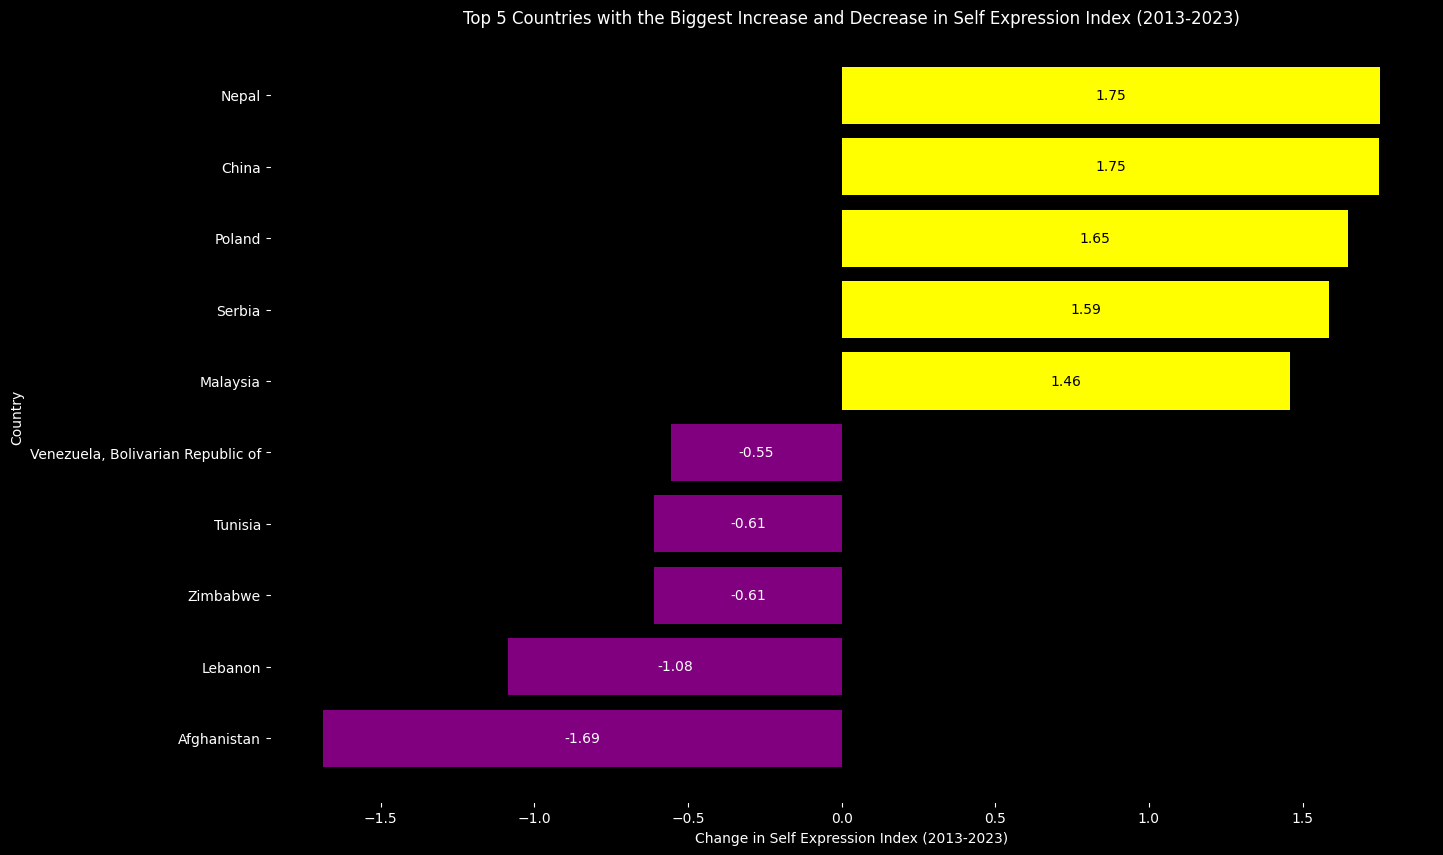

In [10]:
top5_growth = result_2.nlargest(5, 'Change')
top5_decline = result_2.nsmallest(5, 'Change')

top_changes = pd.concat([top5_growth, top5_decline]).sort_values(by='Change', ascending=True)

plt.figure(figsize=(15, 10), facecolor='black')
ax = plt.subplot(facecolor='black')
bars = ax.barh(top_changes['Country'], top_changes['Change'], color=['yellow' if x > 0 else 'purple' for x in top_changes['Change']])

ax.set_ylabel('Country', color='white')
ax.set_xlabel('Change in Self Expression Index (2013-2023)', color='white')
ax.set_title('Top 5 Countries with the Biggest Increase and Decrease in Self Expression Index (2013-2023)', color='white')

ax.tick_params(colors='white')

for bar in bars:
    width = bar.get_width()
    color = 'black' if width > 0 else 'white'
    ax.text(bar.get_width() / 2, bar.get_y() + bar.get_height() / 2, f'{width:.2f}',
            ha='center', va='center', color=color)

plt.show()


Теперь перейдём к этапу, где мы считаем, то насколько концепция Долгого Мира применима к разным странам. В первую очередь, концепция применима к либеральным демократиям, так как демократизация, произошедшая в западном мире после окончания Второй Мировой Войны, на ряду с глобализацией рассматривается как основной фактор появления Долгого Мира. Так как сначала мы будем рассматривать индекс на 2013 год, давайте посчитаем, какие страны были демократическими в период 1946-2013. Для этого я загружу таблицу со страницы https://ourworldindata.org/grapher/liberal-democracy-index?time=1946 в личную директорию и пронанализирую таким образом, потому что Our World of Data запрещает автоматическое скачивание файлов:

In [11]:
file_path = folder + 'liberal-democracy-index.csv'
data = pd.read_csv(file_path)

filtered_data_1946_2013 = data[(data['Year'] >= 1946) & (data['Year'] <= 2013)]
filtered_data_2014_2023 = data[(data['Year'] >= 2014) & (data['Year'] <= 2023)]

average_index_1946_2013 = filtered_data_1946_2013.groupby(['Entity', 'Code'])['Liberal democracy index (best estimate, aggregate: average)'].mean().reset_index()
average_index_2014_2023 = filtered_data_2014_2023.groupby(['Entity', 'Code'])['Liberal democracy index (best estimate, aggregate: average)'].mean().reset_index()

average_index_1946_2013 = average_index_1946_2013.rename(columns={
    'Entity': 'Country',
    'Code': 'Country Code',
    'Liberal democracy index (best estimate, aggregate: average)': 'Average Liberal Democracy Index (1946-2013)'
})

average_index_2014_2023 = average_index_2014_2023.rename(columns={
    'Entity': 'Country',
    'Code': 'Country Code',
    'Liberal democracy index (best estimate, aggregate: average)': 'Average Liberal Democracy Index (2014-2023)'
})

average_index = pd.merge(average_index_1946_2013, average_index_2014_2023, on=['Country', 'Country Code'], how='left')

average_index['Difference'] = average_index['Average Liberal Democracy Index (2014-2023)'] - average_index['Average Liberal Democracy Index (1946-2013)']

average_index.to_excel(folder + 'lib_dem.xlsx', index=False)

average_index.sample(5)

,Country,Country Code,Average Liberal Democracy Index (1946-2013),Average Liberal Democracy Index (2014-2023),Difference
54,Fiji,FJI,0.276794,0.2761,-0.000694
109,Myanmar,MMR,0.072941,0.1636,0.090659
139,Seychelles,SYC,0.209191,0.5464,0.337209
88,Latvia,LVA,0.254662,0.7527,0.498038
71,Iceland,ISL,0.742662,0.7704,0.027738


In [12]:
file_path = folder + 'death-rate-in-armed-conflicts.csv'
data = pd.read_csv(file_path)

filtered_data_1989_2013 = data[(data['Year'] >= 1989) & (data['Year'] <= 2013)]
filtered_data_2014_2023 = data[(data['Year'] >= 2014) & (data['Year'] <= 2023)]

average_death_rate_1989_2013 = filtered_data_1989_2013.groupby(['Entity', 'Code'])['Death rate in ongoing conflicts in a country (best estimate) - Conflict type: all'].mean().reset_index()
average_death_rate_2014_2023 = filtered_data_2014_2023.groupby(['Entity', 'Code'])['Death rate in ongoing conflicts in a country (best estimate) - Conflict type: all'].mean().reset_index()

average_death_rate_1989_2013 = average_death_rate_1989_2013.rename(columns={
    'Entity': 'Country',
    'Code': 'Country Code',
    'Death rate in ongoing conflicts in a country (best estimate) - Conflict type: all': 'Average Death Rate (1989-2013)'
})

average_death_rate_2014_2023 = average_death_rate_2014_2023.rename(columns={
    'Entity': 'Country',
    'Code': 'Country Code',
    'Death rate in ongoing conflicts in a country (best estimate) - Conflict type: all': 'Average Death Rate (2014-2023)'
})

average_death_rate = pd.merge(average_death_rate_1989_2013, average_death_rate_2014_2023, on=['Country', 'Country Code'], how='left')

average_death_rate.to_excel(folder + 'death_rate.xlsx', index=False)

average_death_rate.sample(5)

,Country,Country Code,Average Death Rate (1989-2013),Average Death Rate (2014-2023)
197,Western Sahara,ESH,3.148932,0.000000
167,South Sudan,SSD,35.271288,10.193947
181,Trinidad and Tobago,TTO,0.123172,0.000000
126,Netherlands,NLD,0.000535,0.000000
186,Uganda,UGA,2.967174,0.060528


In [13]:
merged_df = pd.merge(average_index, average_death_rate, on=['Country', 'Country Code'], suffixes=('_lib_dem', '_death_rate'))

merged_df.to_excel(folder + 'merged_data.xlsx', index=False)

merged_df.sample(5)

,Country,Country Code,Average Liberal Democracy Index (1946-2013),Average Liberal Democracy Index (2014-2023),Difference,Average Death Rate (1989-2013),Average Death Rate (2014-2023)
137,Seychelles,SYC,0.209191,0.5464,0.337209,0.000000,0.000000
64,Guinea,GIN,0.060456,0.1355,0.075044,0.551202,0.025243
168,Uruguay,URY,0.590235,0.8165,0.226265,0.000000,0.000000
91,Libya,LBY,0.073746,0.1468,0.073054,3.000239,16.737583
166,United Kingdom,GBR,0.739544,0.7902,0.050656,0.014713,0.000499


In [14]:
def calculate_new_value(F, C):
    if F > 100:
        return 0 + C / 0.9 * 5
    elif F < 0.1:
        return 5 + C / 0.9 * 5
    else:
        return (np.log(100) - np.log(F)) / (np.log(100) - np.log(0.1)) * 5 + C / 0.9 * 5

merged_df['Calculated_Value_2013'] = merged_df.apply(lambda row: calculate_new_value(row['Average Death Rate (1989-2013)'], row['Average Liberal Democracy Index (1946-2013)']), axis=1)

merged_df.to_excel(folder + 'merged_data.xlsx', index=False)

merged_df.sample(5)

,Country,Country Code,Average Liberal Democracy Index (1946-2013),Average Liberal Democracy Index (2014-2023),Difference,Average Death Rate (1989-2013),Average Death Rate (2014-2023),Calculated_Value_2013
0,Afghanistan,AFG,0.080265,0.1536,0.073335,27.042634,55.769586,1.392500
34,Costa Rica,CRI,0.710515,0.8418,0.131285,0.000000,0.000000,8.947304
21,Burkina Faso,BFA,0.197149,0.4095,0.212351,0.000000,3.375428,6.095274
156,Tanzania,TZA,0.259985,0.3617,0.101715,0.030406,0.009004,6.444363
27,Central African Republic,CAF,0.118045,0.1931,0.075055,2.699722,19.812641,3.270276


In [17]:
def calculate_new_value_2(G, E):
    if G > 100:
        return -2 + E / 0.9 * 5
    elif G < 0.1:
        return 0 + E / 0.9 * 5
    else:
        return -2 + (np.log(100) - np.log(G)) / (np.log(100) - np.log(0.1)) * 2 + E / 0.9 * 5

merged_df['Calculated_Difference'] = merged_df.apply(lambda row: calculate_new_value_2(row['Average Death Rate (2014-2023)'], row['Difference']), axis=1)

merged_df.to_excel(folder + 'merged_data.xlsx', index=False)

merged_df.sample(5)

,Country,Country Code,Average Liberal Democracy Index (1946-2013),Average Liberal Democracy Index (2014-2023),Difference,Average Death Rate (1989-2013),Average Death Rate (2014-2023),Calculated_Value_2013,Calculated_Difference
69,Hungary,HUN,0.322294,0.4031,0.080806,0.000000,0.000000,6.790523,0.448922
16,Bolivia,BOL,0.239103,0.3408,0.101697,0.023276,0.004588,6.328350,0.564984
43,Dominican Republic,DOM,0.191118,0.3588,0.167682,0.000000,0.000000,6.061765,0.931569
76,Israel,ISR,0.628364,0.6457,0.017336,0.786569,0.222595,6.998014,-0.135363
6,Australia,AUS,0.814779,0.8071,-0.007679,0.000000,0.000890,9.526552,-0.042663


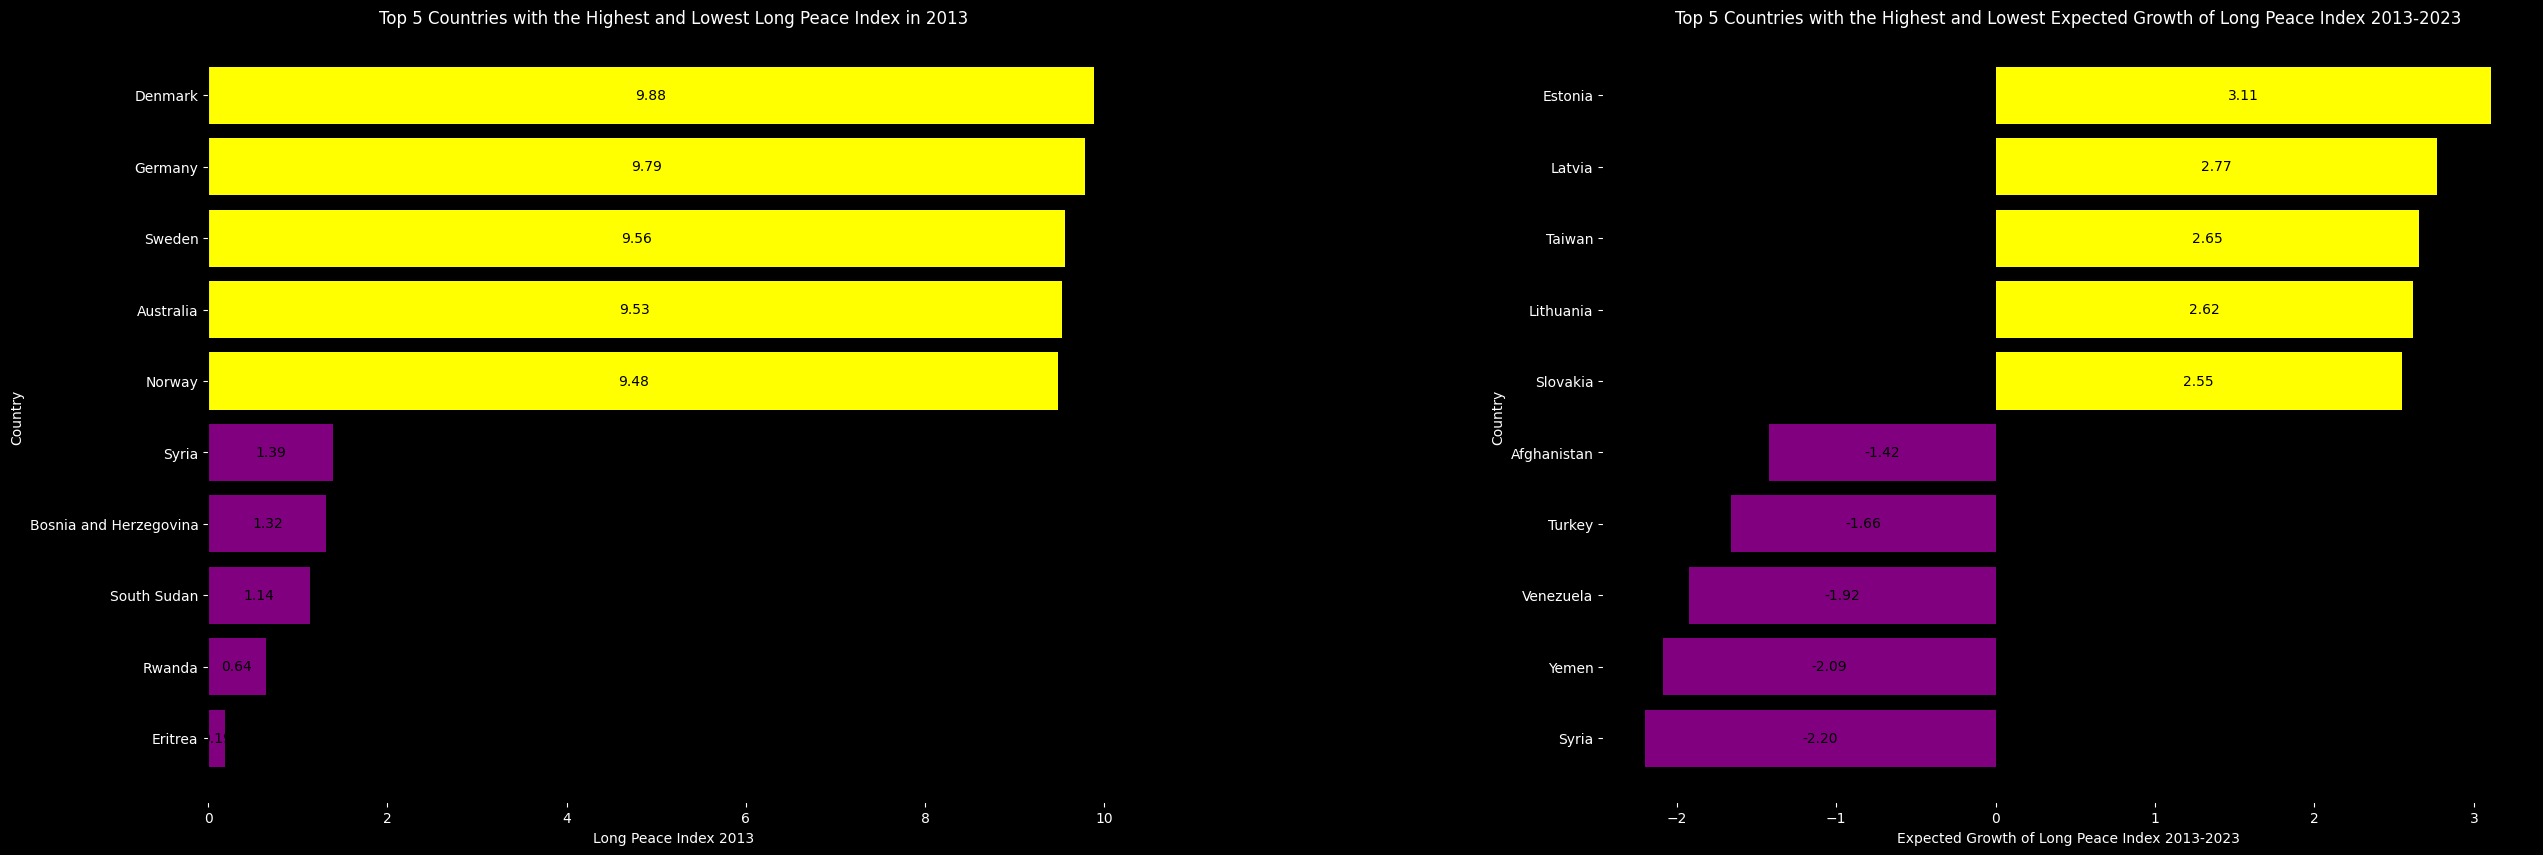

In [19]:
top5_highest_2013 = merged_df.nlargest(5, 'Calculated_Value_2013')
top5_lowest_2013 = merged_df.nsmallest(5, 'Calculated_Value_2013')

top5_highest_2023 = merged_df.nlargest(5, 'Calculated_Difference')
top5_lowest_2023 = merged_df.nsmallest(5, 'Calculated_Difference')

top_2013 = pd.concat([top5_highest_2013, top5_lowest_2013]).sort_values(by='Calculated_Value_2013', ascending=True)
top_2023 = pd.concat([top5_highest_2023, top5_lowest_2023]).sort_values(by='Calculated_Difference', ascending=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10), facecolor='black')
fig.subplots_adjust(wspace=0.5)

ax1.set_facecolor('black')
colors_2013 = ['purple' if i in top5_lowest_2013.index else 'yellow' for i in top_2013.index]
bars1 = ax1.barh(top_2013['Country'], top_2013['Calculated_Value_2013'], color=colors_2013)

ax1.set_ylabel('Country', color='white')
ax1.set_xlabel('Long Peace Index 2013', color='white')
ax1.set_title('Top 5 Countries with the Highest and Lowest Long Peace Index in 2013', color='white')
ax1.tick_params(colors='white')

for bar in bars1:
    width = bar.get_width()
    ax1.text(width / 2, bar.get_y() + bar.get_height() / 2, f'{width:.2f}',
             ha='center', va='center', color='black')

ax2.set_facecolor('black')
colors_2023 = ['purple' if i in top5_lowest_2023.index else 'yellow' for i in top_2023.index]
bars2 = ax2.barh(top_2023['Country'], top_2023['Calculated_Difference'], color=colors_2023)

ax2.set_ylabel('Country', color='white')
ax2.set_xlabel('Expected Growth of Long Peace Index 2013-2023', color='white')
ax2.set_title('Top 5 Countries with the Highest and Lowest Expected Growth of Long Peace Index 2013-2023', color='white')
ax2.tick_params(colors='white')

for bar in bars2:
    width = bar.get_width()
    ax2.text(width / 2, bar.get_y() + bar.get_height() / 2, f'{width:.2f}',
             ha='center', va='center', color='black')

plt.show()

In [39]:
merged_df = merged_df.rename(columns={'Country Code': 'Code'})

combined_df = pd.merge(result_2, merged_df, on='Code', how='left')

combined_df = combined_df.loc[combined_df['Country_x'] != 'Hong Kong']

combined_df.to_excel(folder + 'final_table.xlsx', index=False)

combined_df.sample(5)

,Country_x,Index_2023,Index_2013,Self_Expression_2013,Self_Expression_2023,Change,Code,Country_y,Average Liberal Democracy Index (1946-2013),Average Liberal Democracy Index (2014-2023),Difference,Average Death Rate (1989-2013),Average Death Rate (2014-2023),Calculated_Value_2013,Calculated_Difference
12,Canada,6.961,7.477,7.418,7.065,-0.353,CAN,Canada,0.730676,0.7632,0.032524,0.006860,0.000000,9.059314,0.180686
64,Viet Nam,5.763,5.533,5.089,5.875,0.786,VNM,Vietnam,0.084605,0.1156,0.030995,0.000000,0.000000,5.470029,0.172193
108,Uganda,4.432,4.443,4.315,4.603,0.288,UGA,Uganda,0.149441,0.2209,0.071459,2.967174,0.060528,3.376324,0.396993
23,Romania,6.589,5.033,3.575,4.719,1.144,ROU,Romania,0.182868,0.5674,0.384532,0.078638,0.000000,6.015931,2.136291
2,Iceland,7.530,7.355,7.175,7.475,0.300,ISL,Iceland,0.742662,0.7704,0.027738,0.000000,0.000000,9.125899,0.154101


In [75]:
corr_2013, p_value_2013 = pearsonr(combined_df['Self_Expression_2013'],combined_df['Calculated_Value_2013'])
corr_diff, p_value_diff = pearsonr(combined_df['Change'], combined_df['Calculated_Difference'])
print(round(corr_2013 * 100, 2), round(p_value_2013 * 100, 2))
print(round(corr_diff * 100, 2), round(p_value_diff * 100, 2))

corr_2013, p_value_2013 = spearmanr(combined_df['Self_Expression_2013'],combined_df['Calculated_Value_2013'])
corr_diff, p_value_diff = spearmanr(combined_df['Change'], combined_df['Calculated_Difference'])
print(round(corr_2013 * 100, 2), round(p_value_2013 * 100, 2))
print(round(corr_diff * 100, 2), round(p_value_diff * 100, 2))

68.89 0.0
25.99 0.27
55.58 0.0
19.39 2.65


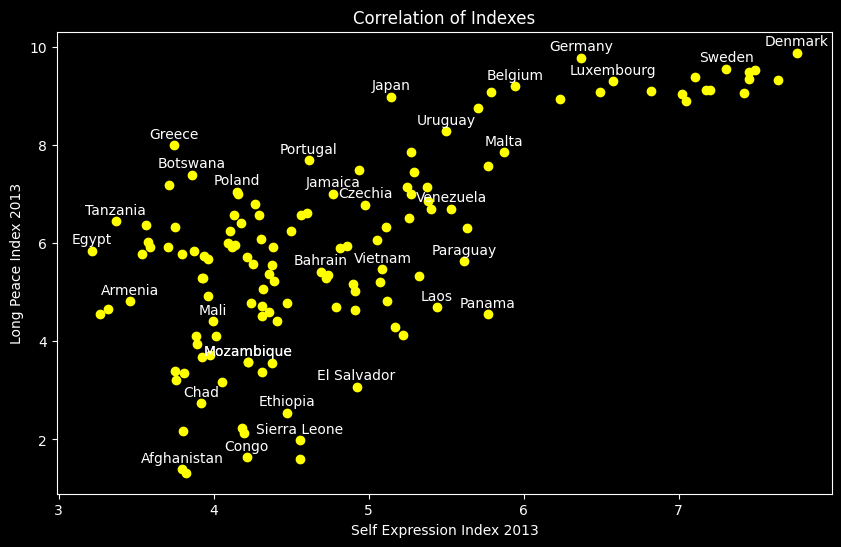

In [74]:
plt.style.use('dark_background')

plt.figure(figsize=(10, 6))
plt.scatter(combined_df['Self_Expression_2013'], combined_df['Calculated_Value_2013'], color='yellow')

countries_to_annotate = [
    'Germany', 'El Salvador', 'Ethiopia', 'Sierra Leone', 'Panama',
    'Egypt', 'Chad', 'Laos', 'Afghanistan', 'Paraguay', 'Venezuela',
    'Japan', 'Greece', 'Botswana', 'Tanzania', 'Congo', 'Portugal',
    'Uruguay', 'Denmark', 'Sweden', 'Luxembourg', 'Malta', 'Belgium',
    'Armenia', 'Poland', 'Jamaica', 'Vietnam', 'Czechia', 'Mozambique',
    'Mali', 'Bahrain']

for i, row in combined_df.iterrows():
    if row['Country_y'] in countries_to_annotate:
        plt.annotate(row['Country_y'], (row['Self_Expression_2013'], row['Calculated_Value_2013']),
                     textcoords='offset points', xytext=(0, 5), ha='center', color='white')

plt.xlabel('Self Expression Index 2013', color='white')
plt.ylabel('Long Peace Index 2013', color='white')
plt.title('Correlation of Indexes', color='white')

plt.show()

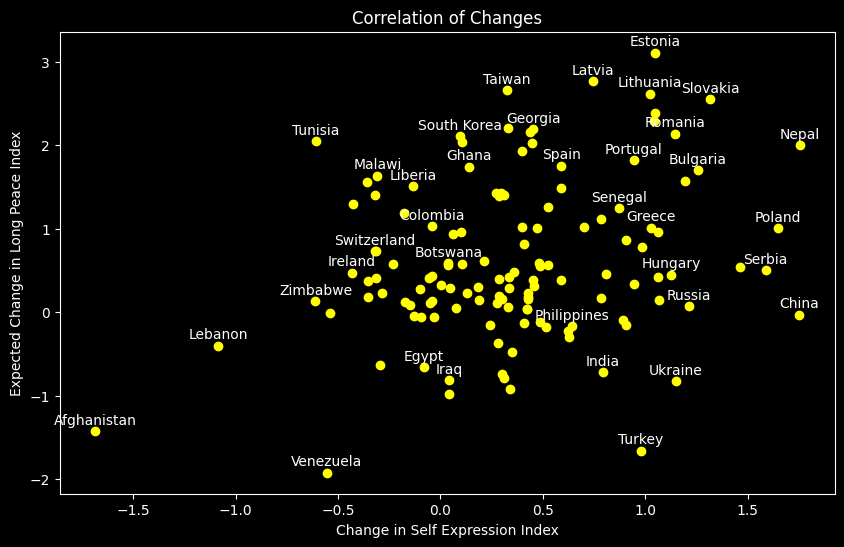

In [64]:
plt.style.use('dark_background')

plt.figure(figsize=(10, 6))
plt.scatter(combined_df['Change'], combined_df['Calculated_Difference'], color='yellow')

countries_to_annotate = [
    'Afghanistan', 'Estonia', 'Slovakia', 'Latvia', 'Lebanon', 'Tunisia', 'Nepal', 'Turkey',
    'Greece', 'Poland', 'Ukraine', 'Venezuela', 'Lebanon', 'Lithuania', 'India', 'China', 'Taiwan',
    'Russia', 'Spain', 'Iraq', 'Zimbabwe', 'South Korea', 'Ireland', 'Egypt', 'Liberia', 'Bulgaria',
    'Portugal', 'Hungary', 'Serbia', 'Switzerland', 'Colombia', 'Malawi', 'Ghana', 'Georgia', 'Romania',
    'Senegal', 'Philippines', 'Botswana']

for i, row in combined_df.iterrows():
    if row['Country_y'] in countries_to_annotate:
        plt.annotate(row['Country_y'], (row['Change'], row['Calculated_Difference']),
                     textcoords='offset points', xytext=(0, 5), ha='center', color='white')

plt.xlabel('Change in Self Expression Index', color='white')
plt.ylabel('Expected Change in Long Peace Index', color='white')
plt.title('Correlation of Changes', color='white')

plt.show()

Regression analysis for 2013:
                             OLS Regression Results                             
Dep. Variable:     Self_Expression_2013   R-squared:                       0.475
Model:                              OLS   Adj. R-squared:                  0.471
Method:                   Least Squares   F-statistic:                     116.5
Date:                  Sun, 09 Jun 2024   Prob (F-statistic):           9.47e-20
Time:                          10:54:26   Log-Likelihood:                -154.55
No. Observations:                   131   AIC:                             313.1
Df Residuals:                       129   BIC:                             318.9
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

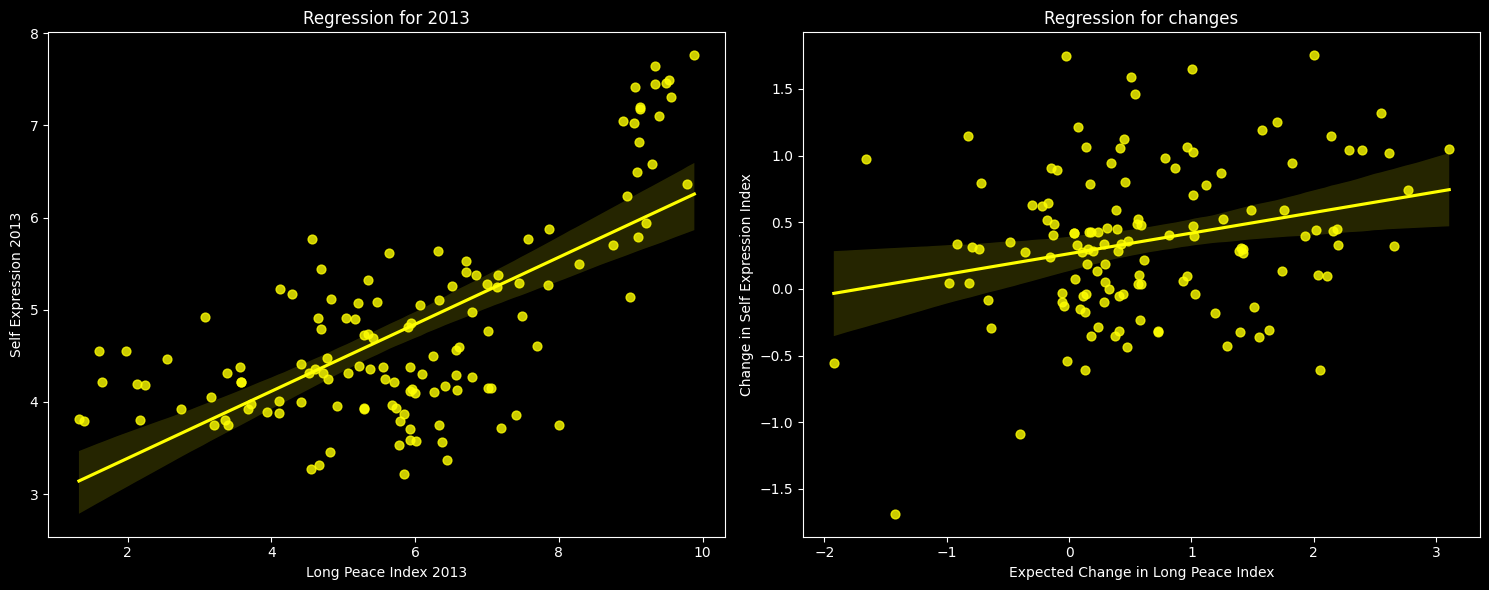

In [84]:
X_2013 = combined_df[['Calculated_Value_2013']]
y_2013 = combined_df['Self_Expression_2013']
X_2013 = sm.add_constant(X_2013)

model_2013 = sm.OLS(y_2013, X_2013).fit()
print("Regression analysis for 2013:")
print(model_2013.summary())

X_diff = combined_df[['Calculated_Difference']]
y_diff = combined_df['Change']
X_diff = sm.add_constant(X_diff)

model_diff = sm.OLS(y_diff, X_diff).fit()
print("Regression analysis for changes:")
print(model_diff.summary())

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.regplot(ax=axes[0], x='Calculated_Value_2013', y='Self_Expression_2013', data=combined_df, color='yellow', scatter_kws={'s': 40, 'color': 'yellow'}, line_kws={'color': 'yellow'})
axes[0].set_title('Regression for 2013')
axes[0].set_xlabel('Long Peace Index 2013')
axes[0].set_ylabel('Self Expression 2013')

sns.regplot(ax=axes[1], x='Calculated_Difference', y='Change', data=combined_df, color='yellow', scatter_kws={'s': 40, 'color': 'yellow'}, line_kws={'color': 'yellow'})
axes[1].set_title('Regression for changes')
axes[1].set_xlabel('Expected Change in Long Peace Index')
axes[1].set_ylabel('Change in Self Expression Index')

plt.tight_layout()
plt.show()

Shapiro-Wilk test for Self_Expression_2013:
ShapiroResult(statistic=0.8937966823577881, pvalue=3.347203403336607e-08)

Shapiro-Wilk test for Change:
ShapiroResult(statistic=0.9825133681297302, pvalue=0.09033414721488953)


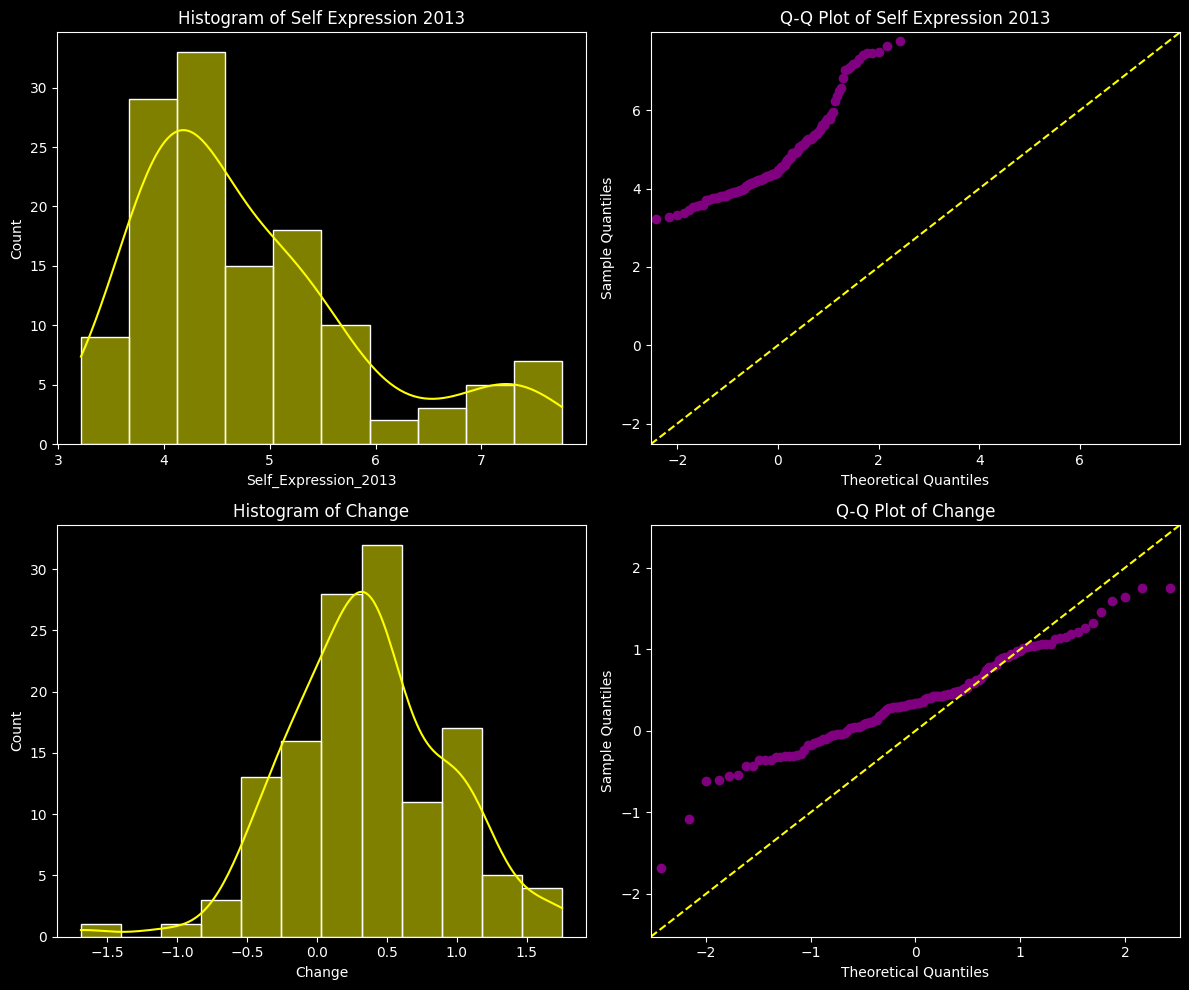

In [91]:
shapiro_test_2013 = stats.shapiro(combined_df['Self_Expression_2013'])
shapiro_test_diff = stats.shapiro(combined_df['Change'])

print("Shapiro-Wilk test for Self_Expression_2013:")
print(shapiro_test_2013)
print("\nShapiro-Wilk test for Change:")
print(shapiro_test_diff)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(combined_df['Self_Expression_2013'], ax=axes[0, 0], kde=True, color='yellow')
axes[0, 0].set_title('Histogram of Self Expression 2013')

sm.qqplot(combined_df['Self_Expression_2013'], line ='45', ax=axes[0, 1])
axes[0, 1].get_lines()[1].set_color('yellow')
axes[0, 1].get_lines()[1].set_linestyle('--')
axes[0, 1].get_lines()[0].set_markerfacecolor('purple')
axes[0, 1].get_lines()[0].set_markeredgecolor('purple')
axes[0, 1].set_title('Q-Q Plot of Self Expression 2013')

sns.histplot(combined_df['Change'], ax=axes[1, 0], kde=True, color='yellow')
axes[1, 0].set_title('Histogram of Change')

sm.qqplot(combined_df['Change'], line ='45', ax=axes[1, 1])
axes[1, 1].get_lines()[1].set_color('yellow')
axes[1, 1].get_lines()[1].set_linestyle('--')
axes[1, 1].get_lines()[0].set_markerfacecolor('purple')
axes[1, 1].get_lines()[0].set_markeredgecolor('purple')
axes[1, 1].set_title('Q-Q Plot of Change')

plt.tight_layout()
plt.show()